In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
os.chdir('./drive/MyDrive/Capstone/Capstone1/solarwindPrediction/')

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
train_X_data = pd.read_csv('XGBoost/train_set/train_X_data.csv', index_col='datetime', parse_dates=True)
test_X_data = pd.read_csv('XGBoost/test_set/test_X_data.csv', index_col='datetime', parse_dates=True)
train_Y_data = pd.read_csv('XGBoost/train_set/train_Y_data.csv', index_col='datetime', parse_dates=True)
test_Y_data = pd.read_csv('XGBoost/test_set/test_Y_data.csv', index_col='datetime', parse_dates=True)

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
import torch

# WRMSE 함수 정의
def WRMSE(predictions, answers):
    sum_answer = answers.sum().item()  # DataFrame에서 직접 합 계산
    if sum_answer == 0:
        return torch.sqrt(torch.tensor(0.001, dtype=torch.float))
    weights = answers / sum_answer  # 각 값에 대해 가중치 계산
    loss = (weights * (predictions - answers).pow(2)).sum().item()  # 가중치 적용한 오차 제곱합
    return torch.sqrt(torch.tensor(loss, dtype=torch.float))

# 1. RandomForestRegressor(+ 반올림) - 결측치처리 IterativeImputer 사용
다중 회귀를 사용하여 결측치 예측
- 각 feature에 대해 회귀 모델을 학습하고, 이를 사용하여 결측치 예측

In [ ]:
# IterativeImputer를 사용하여 결측치 처리
imputerIterative = IterativeImputer(random_state=42)
X_train_imputed1 = imputerIterative.fit_transform(train_X_data)
X_test_imputed1 = imputerIterative.transform(test_X_data)

In [ ]:
num_features = train_X_data.shape[1]
max_features_value = int(num_features / 3)

In [ ]:
# RandomForestRegressor 학습 및 평가
modelIterative = RandomForestRegressor(n_estimators=700,
                                       max_features = max_features_value,
                                       max_depth = 15,
                                       min_samples_leaf = 5,
                                       min_samples_split = 15,
                                       )
modelIterative.fit(X_train_imputed1, train_Y_data)

# 예측 및 평가
y_pred1 = modelIterative.predict(X_test_imputed1)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [ ]:
# 예측값을 정수로 변환
preds_rounded1 = np.round(y_pred1).astype(int)

# 예측값을 0~9 사이의 값으로 클리핑
preds_clipped1 = np.clip(preds_rounded1, 0, 9)  # 클리핑 : 데이터의 값을 특정 범위로 제한하는 것. (여기선 0~9로 제한)

In [ ]:
# 평가 (예: RMSE 계산)
rmse = np.sqrt(mean_squared_error(test_Y_data, preds_clipped1))
print(f"RMSE: {rmse}")

RMSE: 0.7205401322561991


In [ ]:
wrmse = WRMSE(y_pred1, test_Y_data['Kp'])
print(wrmse)

tensor(0.7242)


In [ ]:
r2 = r2_score(test_Y_data['Kp'], preds_clipped1)

print(f'Test R^2: {r2}')

Test R^2: 0.6068336122280418


# 2. RandomForestRegressor(+ 반올림) - 결측치처리 SimpleImputer 사용
평균으로 결측치 채움

- mean: 해당 열의 평균으로
- median: 해당 열의 중앙값으로
- most_frequent: 해당 열에서 가장 자주 나타나는 값으로
- constant : 사용자가 지정한 상수로

In [ ]:
from sklearn.impute import SimpleImputer

In [ ]:
# SimpleImputer를 사용하여 결측치 처리
imputerSimple = SimpleImputer(strategy='most_frequent')  # 평균으로 결측치 채우기
X_train_imputed2 = imputerSimple.fit_transform(train_X_data)
X_test_imputed2 = imputerSimple.transform(test_X_data)

In [ ]:
num_features = X_train_imputed2.shape[1]
max_features_value = int(num_features / 3)

In [ ]:
# RandomForestClassifier 학습 및 평가
modelSimple = RandomForestRegressor(n_estimators=700,
                                       max_features = max_features_value,
                                       max_depth = 15,
                                       min_samples_leaf = 5,
                                       min_samples_split = 15
                                    )
modelSimple.fit(X_train_imputed2, train_Y_data)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(max_depth=15, max_features=11, min_samples_leaf=5,
                      min_samples_split=15, n_estimators=700)

In [ ]:
# 예측 및 평가
y_pred2 = modelSimple.predict(X_test_imputed2)

In [ ]:
# 예측값을 정수로 변환
preds_rounded2 = np.round(y_pred2).astype(int)

# 예측값을 0~9 사이의 값으로 클리핑
preds_clipped2 = np.clip(preds_rounded2, 0, 9)  # 클리핑 : 데이터의 값을 특정 범위로 제한하는 것. (여기선 0~9로 제한)

In [ ]:
# 평가 (예: RMSE 계산)
rmse = np.sqrt(mean_squared_error(test_Y_data, preds_clipped2))
print(f"RMSE: {rmse}")

RMSE: 0.7233862531406556


In [ ]:
wrmse = WRMSE(preds_clipped2, test_Y_data['Kp'])
print(wrmse)

tensor(0.7712)


In [ ]:
r2 = r2_score(test_Y_data['Kp'], preds_clipped2)

print(f'Test R^2: {r2}')

Test R^2: 0.6008250893584371


In [ ]:
# MAE 계산
mae = mean_absolute_error(test_Y_data['Kp'], preds_clipped2)

# MAPE 계산
mape = np.mean(np.abs((test_Y_data['Kp'] - preds_clipped2) / test_Y_data['Kp'])) * 100

print(f'MAE: {mae}')
print(f'MAPE: {mape:.2f}%')

MAE: 0.4657534246575342
MAPE: inf%


## Confusion Matrix 출력

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

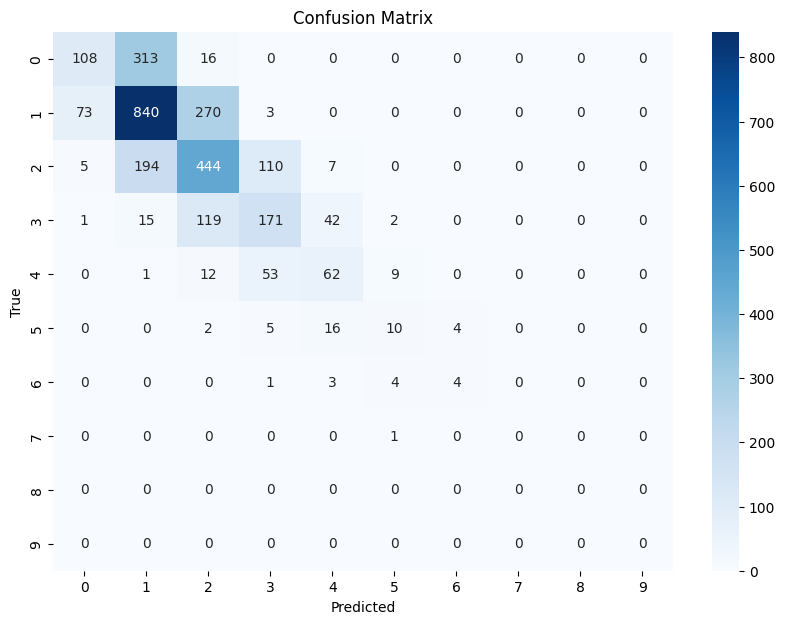

In [ ]:
# 혼동 행렬을 계산합니다.
conf_matrix = confusion_matrix(test_Y_data['Kp'], preds_clipped2, labels=np.arange(10))

# 혼동 행렬을 시각화합니다.
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 3. RandomForestRegressor(+ 반올림) - 결측치처리 KNNImputer 사용
K-최근접 이웃(K-Nearest Neighbors) 알고리즘을 사용
- 결측치가 있는 샘플과 가장 유사한 K개의 이웃 샘플을 찾아서 평균 값으로 결측치 채운다.

In [ ]:
from sklearn.impute import KNNImputer

In [ ]:
# KNNImputer를 사용하여 결측치 처리
imputerKNN = KNNImputer(n_neighbors=10)
X_train_imputed3 = imputerKNN.fit_transform(train_X_data)
X_test_imputed3 = imputerKNN.transform(test_X_data)

In [ ]:
num_features = X_train_imputed3.shape[1]
max_features_value = int(num_features / 3)

In [ ]:
# RandomForestClassifier 학습 및 평가
modelKNN = RandomForestRegressor(n_estimators=700,
                                max_features = max_features_value,
                                max_depth = 15,
                                min_samples_leaf = 5,
                                min_samples_split = 15
                                )
modelKNN.fit(X_train_imputed3, train_Y_data)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(max_depth=15, max_features=11, min_samples_leaf=5,
                      min_samples_split=15, n_estimators=700)

In [ ]:
# 예측 및 평가
y_pred3 = modelKNN.predict(X_test_imputed3)

In [ ]:
# 예측값을 정수로 변환
preds_rounded3 = np.round(y_pred3).astype(int)

# 예측값을 0~9 사이의 값으로 클리핑
preds_clipped3 = np.clip(preds_rounded3, 0, 9)  # 클리핑 : 데이터의 값을 특정 범위로 제한하는 것. (여기선 0~9로 제한)

In [ ]:
# 평가 (예: RMSE 계산)
rmse = np.sqrt(mean_squared_error(test_Y_data, preds_clipped3))
print(f"RMSE: {rmse}")

RMSE: 0.7250413308955906


In [ ]:
wrmse = WRMSE(preds_clipped3, test_Y_data['Kp'])
print(wrmse)

tensor(0.7766)


In [ ]:
r2 = r2_score(test_Y_data['Kp'], preds_clipped3)

print(f'Test R^2: {r2}')

Test R^2: 0.5989964084850792


In [ ]:
# MAE 계산
mae = mean_absolute_error(test_Y_data['Kp'], preds_clipped3)

# MAPE 계산
mape = np.mean(np.abs((test_Y_data['Kp'] - preds_clipped3) / test_Y_data['Kp'])) * 100

print(f'MAE: {mae}')
print(f'MAPE: {mape:.2f}%')

MAE: 0.46678082191780823
MAPE: inf%


# 4. 정규분포 사용하여 열마다 다른 결측치 처리

In [ ]:
from scipy.stats import shapiro

# 정규성 검사를 수행할 열을 선택
columns_with_missing_values = train_X_data.columns[train_X_data.isnull().any()]

for column in columns_with_missing_values:
    # 결측치를 제외한 데이터로 정규성 검사
    data_without_na = train_X_data[column].dropna()

    stat, p_value = shapiro(data_without_na)
    print(f"Column: {column}, p-value: {p_value}")

    # p-value가 0.05보다 크면 /'정규성을 따른다고 가정
    if p_value > 0.05:
        print(f"{column}: 데이터가 정규 분포를 따릅니다. 평균을 사용합니다.")
    else:
        print(f"{column}: 데이터가 정규 분포를 따르지 않습니다. 최빈값을 사용합니다.")


In [ ]:
from sklearn.impute import SimpleImputer

# Imputer 생성
mean_imputer = SimpleImputer(strategy='mean')
most_frequent_imputer = SimpleImputer(strategy='most_frequent')

# 각 열에 대해 적합한 imputer를 적용하여 결측치 채우기
for column in columns_with_missing_values:
    data_without_na = train_X_data[column].dropna()

    stat, p_value = shapiro(data_without_na)

    if p_value > 0.05:
        # 데이터가 정규 분포를 따르는 경우
        imputer = mean_imputer
    else:
        # 데이터가 정규 분포를 따르지 않는 경우
        imputer = most_frequent_imputer

    # 해당 열을 2차원 배열로 변환하여 imputer 적용
    train_X_data[[column]] = imputer.fit_transform(train_X_data[[column]])

# 결과 확인
print(train_X_data.head())
print(train_X_data.isnull().sum())


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 28554.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 28554.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 28521.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 28554.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.

                     Np_min  Np_max   Np_mean    Np_std  Np_median   Tp_min  \
datetime                                                                      
1999-01-01 03:00:00   4.673   8.972  6.637235  0.699972     6.6295  61702.0   
1999-01-01 06:00:00   4.904   9.705  6.977939  0.891245     6.8650  64082.0   
1999-01-01 09:00:00   4.663   9.960  7.402352  0.785921     7.3520  59304.0   
1999-01-01 12:00:00   5.411   8.917  7.298018  0.635436     7.2980  74835.0   
1999-01-01 15:00:00   4.984   9.327  6.838558  0.624283     6.8200  86183.0   

                       Tp_max        Tp_mean        Tp_std  Tp_median  ...  \
datetime                                                               ...   
1999-01-01 03:00:00  135540.0   86877.080247  12119.616431    85842.0  ...   
1999-01-01 06:00:00  176880.0  102955.228395  17679.980152   101250.0  ...   
1999-01-01 09:00:00  163080.0  109935.283951  18262.240706   114025.0  ...   
1999-01-01 12:00:00  139790.0  107001.884146  11248.8428

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 40901.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 40902.
  res = hypotest_fun_out(*samples, **kwds)


In [ ]:
num_features = train_X_data.shape[1]
max_features_value = int(num_features / 3)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# 모델 생성
rf_regressor = RandomForestRegressor(n_estimators=700,
                                       max_features = max_features_value,
                                       max_depth = 15,
                                       min_samples_leaf = 5,
                                       min_samples_split = 15
                                     )

# 모델 학습
rf_regressor.fit(train_X_data, train_Y_data)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(max_depth=15, max_features=11, min_samples_leaf=5,
                      min_samples_split=15, n_estimators=700)

In [ ]:
# 예측
y_pred_test = rf_regressor.predict(test_X_data)

# 예측값을 정수로 변환
y_pred_test = np.round(y_pred_test).astype(int)

# 예측값을 0~9 사이의 값으로 클리핑
y_pred_test = np.clip(y_pred_test, 0, 9)  # 클리핑 : 데이터의 값을 특정 범위로 제한하는 것. (여기선 0~9로 제한)

# 성능 평가
rmse = np.sqrt(mean_squared_error(test_Y_data, y_pred_test))
print(f"RMSE: {rmse}")

RMSE: 0.7248051226042933


In [ ]:
wrmse = WRMSE(y_pred_test, test_Y_data['Kp'])
print(wrmse)

tensor(0.7741)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:

r2 = r2_score(test_Y_data['Kp'], y_pred_test)

print(f'Test R^2: {r2}')

Test R^2: 0.5992576486098447


In [ ]:
# MAE 계산
mae = mean_absolute_error(test_Y_data['Kp'], y_pred_test)

# MAPE 계산
mape = np.mean(np.abs((test_Y_data['Kp'] - y_pred_test) / test_Y_data['Kp'])) * 100

print(f'MAE: {mae}')
print(f'MAPE: {mape:.2f}%')

MAE: 0.4657534246575342
MAPE: inf%
